In [3]:
import numpy as np
from cell_paint_seg.utils import get_id_to_path, check_valid_labels, threat_score
from cell_paint_seg.image_io import read_ims, read_seg
from skimage import io, exposure, measure
from pathlib import Path
import napari
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score 

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (co

In [4]:
def id_from_name(name):
    name_nospace = name.replace(" ", "")
    exp = name_nospace[10]
    field = name_nospace[-10:-6]
    id = f"e{exp}_{field}"
    return id

def id_from_name_mask(name):
    id = name[:7] 
    return id

In [7]:
path_tif = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/og/"
path_gray = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/grayscale/")
path_3ch = Path("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/")

channels = ["ER", "DNA", "Mito", "Actin", "RNA", "Golgi/membrane"]
res = 5.98e-7

id_to_path = get_id_to_path(path_tif, tag=".tif", id_from_name=id_from_name)

print(f"{len(id_to_path.keys())} samples found")


4 samples found


# View data

In [15]:
def id_from_name_2(name):
    name_nospace = name.replace(" ", "")
    exp = name_nospace[10]
    field = name_nospace[-21:-17]
    id = f"e{exp}_{field}"
    return id

path_fig = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/cellpaint"
id_to_path_fig = get_id_to_path(path_fig, tag="_8bit.tif", id_from_name=id_from_name_2)

id = "e1_s026"

paths = id_to_path_fig[id]
ims = read_ims(paths)
ims = [im.astype(np.float32) for im in ims]
im_rgb = np.stack([ims[3], ims[4], ims[1]], axis=-1)

im_rgb_2 = np.stack([ims[0]+ims[5], ims[4], ims[1]], axis=-1)

len(ims)

viewer = napari.Viewer()
for im in ims:  
    viewer.add_image(im, scale=[res, res])
viewer.add_image(im_rgb, rgb=True, scale=[res, res])
viewer.add_image(im_rgb_2, rgb=True, scale=[res, res])

viewer.scale_bar.visible = True
viewer.scale_bar.unit = "m"


In [20]:
path_fig = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/figures/cellpaint"
id_to_path_fig = get_id_to_path(path_fig, tag=".tif", id_from_name=id_from_name)

id = "e1_s026"

paths = id_to_path_fig[id]
ims = read_ims(paths)

for path, im in zip(paths, ims):
    im_mip = np.amax(im, axis=-1)
    im_mip_clahe = exposure.equalize_adapthist(im_mip, clip_limit=0.03, kernel_size=16)
    
    path = Path(path)
    path_new = path.parent / (path.stem + "_clahe.tif")
    io.imsave(path_new, im_mip_clahe)

    im_mip_clahe_8bit = (im_mip_clahe * 255).astype(np.uint8)
    path_new = path.parent / (path.stem + "_clahe_8bit.tif")
    io.imsave(path_new, im_mip_clahe_8bit)


In [29]:
im_rgb = io.imread("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/segmentation/e1_s026.tif")
im_rgb.shape

im_rna = im_rgb[:,:, 1]
im_rna_clahe = exposure.equalize_adapthist(im_rna, clip_limit=0.03, kernel_size=16)
im_rna_clahe_8bit = (im_rna_clahe * 255).astype(np.uint8)
io.imsave("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/segmentation/e1_s026_rna_clahe_8bit.tif", im_rna_clahe_8bit)

# Random image selection/Convert

In [ ]:
line_names = ["ADK", "AE8", "NK3", "XH7", "ZKZ"]

for line_name in line_names:
    well = np.random.randint(1,3)
    field = np.random.randint(1,4)
    print(f"{line_name} well {well} field {field}")

ADK well 1 field 2 -> exp4, s062

AE8 well 1 field 2 -> exp 1, s026

NK3 well 1 field 3 ->  exp 3, s090

XH7 well 1 field 2 -> exp 2, s089

ZKZ well 1 field 2 -> exp 1, s062

In [21]:
for id in id_to_path.keys():
    ims = read_ims(id_to_path[id])
    ims = [np.amax(im, axis=-1) for im in ims]

    for c, im in enumerate(ims):
        path = path_gray / f"{id}_c{c+1}.tif"
        io.imsave(path, im)
    
    # ims = [im.astype(np.float32) for im in ims]
    # im_3channel = np.stack([ims[3], ims[4], ims[1]], axis=-1)
    # im_3channel = im_3channel.astype(np.uint8)

    # io.imsave(path_3ch / f"{id}_ard.tif", im_3channel)




# Resolve segmentations

In [10]:
path_resolve = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_resolve = Path(path_resolve)

In [11]:
id_to_path = get_id_to_path(path_3ch, tag=".tif", id_from_name=id_from_name_mask)
id_to_path_nuc = get_id_to_path(path_resolve, tag="nuc.", id_from_name=id_from_name_mask)
id_to_path_soma = get_id_to_path(path_resolve, tag="soma.", id_from_name=id_from_name_mask)
id_to_path_cell = get_id_to_path(path_resolve, tag="cell.", id_from_name=id_from_name_mask)

In [13]:
ids = id_to_path_nuc.keys()
#ids = ["e2_s089"]
scale_on = False

for id in ids:
    if "e1" in id:
        continue
    im = read_seg(id_to_path[id])
    mask_nuc = read_seg(id_to_path_nuc[id])
    mask_soma = read_seg(id_to_path_soma[id])
    mask_cell = read_seg(id_to_path_cell[id])


    soma_to_nuc = {}
    # compute nuc-soma matches
    for nuc_id in np.unique(mask_nuc[mask_nuc > 0]):
        nuc_area = np.sum(mask_nuc == nuc_id)
        soma_ids, overlap_areas = np.unique(mask_soma[mask_nuc == nuc_id], return_counts=True)

        for soma_id, overlap_area in zip(soma_ids, overlap_areas):
            if soma_id == 0:
                continue 

            if overlap_area/nuc_area > 0.5: # if soma is more than half of nuc, only happens once per nuc
                if soma_id in soma_to_nuc.keys(): # if soma is already assigned to a nuc
                    if overlap_area > soma_to_nuc[soma_id][1]: # soma is assigned to nuc with larger overlap area
                        soma_to_nuc[soma_id] = (nuc_id, overlap_area)
                else:
                    soma_to_nuc[soma_id] = (nuc_id, overlap_area)

                break

    cell_to_soma = {}
    # compute soma-cell matches
    for soma_id in np.unique(mask_soma[mask_soma > 0]):
        soma_area = np.sum(mask_soma == soma_id)
        mask_cell_crop = mask_cell[mask_soma == soma_id]
        cell_ids, overlap_areas = np.unique(mask_cell_crop, return_counts = True)

        for cell_id, overlap_area in zip(cell_ids, overlap_areas):
            if cell_id == 0:
                continue
            if overlap_area/soma_area > 0.5: 
                if cell_id in cell_to_soma.keys():
                    if overlap_area > cell_to_soma[cell_id][1]:
                        cell_to_soma[cell_id] = (soma_id, overlap_area)
                else:
                    cell_to_soma[cell_id] = (soma_id, overlap_area) 

                break

    triplets = []
    for cell_id in cell_to_soma.keys():
        try:
            soma_id = cell_to_soma[cell_id][0]
            nuc_id = soma_to_nuc[soma_id][0]
            triplets.append((nuc_id, soma_id, cell_id))
        except KeyError:
            continue


    print(f"{len(triplets)} matches found for {id} w/{[len(np.unique(im))-1 for im in [mask_nuc, mask_soma, mask_cell]]}")

    # combine segmentations
    mask_nuc_resolved = np.zeros_like(mask_nuc)
    mask_soma_resolved = np.zeros_like(mask_soma)
    mask_cell_resolved = np.zeros_like(mask_cell)
    for counter, match in enumerate(triplets):
        new_label = counter + 1

        mask_nuc_resolved[mask_nuc == match[0]] = new_label

        mask_soma_resolved[mask_nuc_resolved == new_label] = new_label
        mask_soma_resolved[np.logical_and(mask_soma == match[1], mask_nuc == 0)] = new_label

        mask_cell_resolved[mask_soma_resolved == new_label] = new_label
        uncovered = np.logical_and(mask_soma == 0, mask_nuc == 0)
        mask_cell_resolved[np.logical_and(mask_cell == match[2], uncovered)] = new_label


    check_valid_labels(mask_nuc_resolved, mask_soma_resolved, mask_cell_resolved)
    
    if scale_on:
        scale = (res,res)
    else:
        scale = None

    mask_nuc_unresolved = np.copy(mask_nuc)
    mask_soma_unresolved = np.copy(mask_soma)
    mask_cell_unresolved = np.copy(mask_cell)
    for match in triplets:
        mask_nuc_unresolved[mask_nuc_unresolved == match[0]] = 0
        mask_soma_unresolved[mask_soma_unresolved == match[1]] = 0
        mask_cell_unresolved[mask_cell_unresolved == match[2]] = 0

    # viewer = napari.Viewer()
    # viewer.add_image(im, name=f"{id} - 3ch", scale=scale)
    # viewer.add_labels(mask_nuc_unresolved, name=f"{id} - nuc", scale=scale)
    # viewer.add_labels(mask_soma_unresolved, name=f"{id} - soma", scale=scale)
    # viewer.add_labels(mask_cell_unresolved, name=f"{id} - cell", scale=scale)
    # viewer.scale_bar.unit = 'm'
    # viewer.scale_bar.visible = True

    # viewer = napari.Viewer()
    # viewer.add_image(im, name=f"{id} - 3ch", scale=scale)
    # viewer.add_labels(mask_nuc_resolved, name=f"{id} - nuc", scale=scale)
    # viewer.add_labels(mask_soma_resolved, name=f"{id} - soma", scale=scale)
    # viewer.add_labels(mask_cell_resolved, name=f"{id} - cell", scale=scale)
    # viewer.scale_bar.unit = 'm'
    # viewer.scale_bar.visible = True

    
    for comp, mask_resolved in zip(["nuc", "soma", "cell"], [mask_nuc_resolved, mask_soma_resolved, mask_cell_resolved]):
        path_resolved = path_resolve / f"{id}_cp_masks_{comp}_resolved.tif"
        io.imsave(path_resolved, mask_resolved)

        

391 matches found for e4_s062 w/[391, 391, 391]
2 components with id 268 with centroids:
(447.44642857142856, 1005.2321428571429)
(482.12333333333333, 995.0933333333334)


/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_18311/4274313518.py:115: UserWarning: /Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh/e4_s062_cp_masks_nuc_resolved.tif is a low contrast image
  io.imsave(path_resolved, mask_resolved)
/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_18311/4274313518.py:115: UserWarning: /Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh/e4_s062_cp_masks_soma_resolved.tif is a low contrast image
  io.imsave(path_resolved, mask_resolved)
/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_18311/4274313518.py:115: UserWarning: /Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh/e4_s062_cp_masks_cell_resolved.tif is a low contrast image
  io.imsave(path_resolved, mask_resolved)


# Inter-annotator reliability

In [15]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alba = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/alba"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"


tag_to_name = {"nuc": "Nuclei", "soma": "Somas", "cell": "Cells"}


data_val = []
data_metric = []
data_iou = []
data_comp = []

data_semantic_iou = []
data_semantic_comp = []

for path_ann_1, path_ann_2 in tqdm([(path_tommy, path_aneesh), (path_tommy, path_alba), (path_aneesh, path_alba)], desc="annotator pairs..."):
    for compartment in tqdm(["nuc", "soma", "cell"], leave=False, desc="compartments..."):
        id_to_paths_ann1 = get_id_to_path(path_ann_1, id_from_name_mask, tag=f"_{compartment}_resolved")
        id_to_paths_ann2 = get_id_to_path(path_ann_2, id_from_name_mask, tag=f"_{compartment}_resolved")

        for id, path in tqdm(id_to_paths_ann2.items(), leave=False, desc="ids..."):
            seg_ann2 = read_seg(path)
            seg_ann1 = read_seg(id_to_paths_ann1[id])

            seg_binary1 = seg_ann1 > 0
            seg_binary2 = seg_ann2 > 0
            semantic_iou = np.sum(np.logical_and(seg_binary1, seg_binary2)) / np.sum(np.logical_or(seg_binary1, seg_binary2))
            data_semantic_iou.append(semantic_iou)
            data_semantic_comp.append(tag_to_name[compartment])

            for iou_thresh in tqdm(np.arange(0.5, 1.0, 0.1), leave=False, desc="IoU thresholds..."):
                tps, fps, fns = threat_score(seg_ann1, seg_ann2, iou_thresh)
                prec = tps / (tps + fps)
                rec = tps / (tps + fns)
                threat = tps / (tps + fps + fns)
                for metric, val in zip(["Threat Score", "Precision", "Recall"], [threat, prec, rec]):
                    data_iou.append(iou_thresh)
                    data_metric.append(metric)
                    data_val.append(val)
                    data_comp.append(tag_to_name[compartment])

df = pd.DataFrame({"IoU Threshold": data_iou, "Value": data_val, "Metric": data_metric, "Compartment": data_comp})
df_semantic = pd.DataFrame({"Semantic IoU": data_semantic_iou, "Compartment": data_semantic_comp})

annotator pairs...:   0%|          | 0/3 [00:00<?, ?it/s]

compartments...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/2 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/2 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/2 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

compartments...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/1 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/1 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/1 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

compartments...:   0%|          | 0/3 [00:00<?, ?it/s]

ids...:   0%|          | 0/1 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/1 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/1 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

(0.0, 1.0)

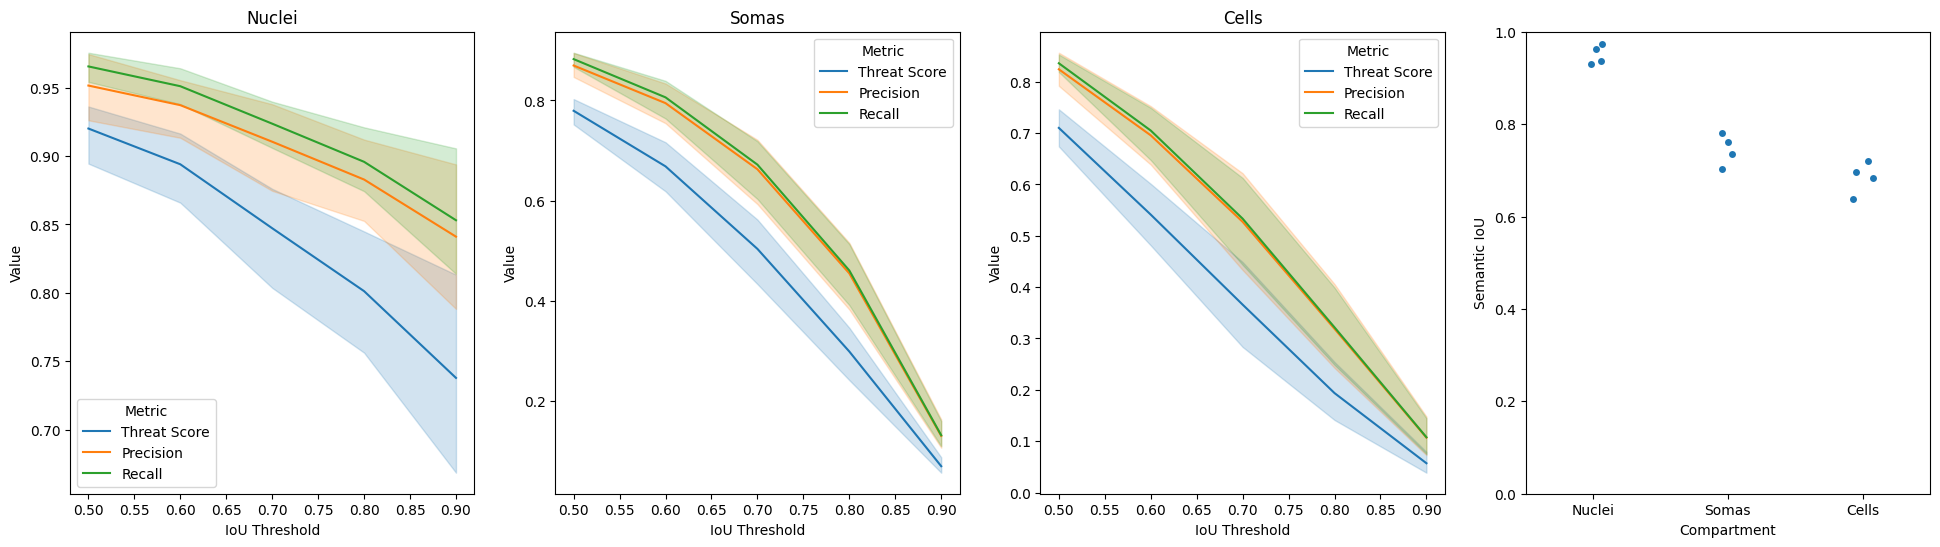

In [16]:
f, axs = plt.subplots(1, 4, figsize=(24, 6))

for compartment, ax in zip(["Nuclei", "Somas", "Cells"], axs):
    sns.lineplot(data=df[df["Compartment"] == compartment ], x="IoU Threshold", y="Value", hue="Metric", ax=ax)
    ax.set_title(compartment)

plt.ylim(0, 1.0)

sns.stripplot(data=df_semantic, x="Compartment", y="Semantic IoU", ax=axs[-1])
plt.ylim(0, 1.0)


#plt.suptitle("Tommy vs Aneesh Agreement")
#plt.savefig("./data/figures/results/threat.svg")

In [87]:
viewer = napari.Viewer()
ra = viewer.add_image(np.eye(10))

## View different annotations

In [ ]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alba = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/alba"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"

id = "e1_s026"

id_to_path_im = get_id_to_path(path_im, id_from_name_mask, tag=f".tif")
im = read_seg(id_to_path_im[id])


viewer = napari.Viewer()
viewer.add_image(im, rgb=True, scale=(res,res))

for path_ann, name in zip([path_tommy, path_aneesh, path_alba], ["Tommy", "Aneesh", "Alba"]):
    id_to_paths_ann = get_id_to_path(path_ann, id_from_name_mask, tag=f"_resolved")

    segs = read_ims(id_to_paths_ann[id])
    for seg, compartment in zip(segs, ["cell", "nuc", "soma"]):
        viewer.add_labels(seg, name=f"{name}-{compartment}", scale=(res,res))

viewer.scale_bar.unit = 'm'
viewer.scale_bar.visible = True


# Evaluate algorithms

- cellpose - done
- omnipose - done
- cellprofiler (otsu) - done
- https://github.com/selimsef/dsb2018_topcoders/ - #1 kaggle for nuclei # old cuda version


In [48]:
def unq_lbl(seg):
    # convert rgb to grayscale
    if seg.ndim == 3:
        seg_new = np.zeros(seg.shape[:2], dtype=np.uint32)
        seg_new = seg[:,:,0]*256**2 + seg[:,:,1]*256 + seg[:,:,2]
        seg = seg_new

    # separate connected components
    seg_new = np.zeros_like(seg)
    counter = 1
    for lbl in np.unique(seg[seg > 0]):
        label = measure.label(seg == lbl)
        for new_lbl in np.unique(label):
            if new_lbl == 0:
                continue
            seg_new[label == new_lbl] = counter
            counter += 1
    return seg_new


In [ ]:
path_tommy = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/tommy"
path_aneesh = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/aneesh"
path_alg = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cyto3"
path_omni = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/cyto2_omni"
path_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/annotate_3ch/"
path_cellprof = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/annotated/grayscale/cellprofiler/"

paths = {"Tommy": path_tommy, "Aneesh": path_aneesh, "Cellpose Cyto3": path_alg, "Omnipose Cyto2": path_omni, "CellProfiler": path_cellprof}

tag_to_name = {"nuc": "Nuclei", "soma": "Somas", "cell": "Cells"}


data_val = []
data_metric = []
data_iou = []
data_comp = []
data_matchup = []

data_semantic_iou = []
data_semantic_comp = []
data_semantic_matchup = []

for ann1, ann2 in tqdm([("Tommy", "CellProfiler"), ("Tommy", "Omnipose Cyto2"), ("Tommy", "Cellpose Cyto3"), ("Tommy", "Aneesh")], desc="annotator pairs..."):
    path_ann1 = paths[ann1]
    path_ann2 = paths[ann2]
    for compartment in tqdm(["nuc", "soma", "cell"], leave=False, desc="compartments..."):
        id_to_paths_ann1 = get_id_to_path(path_ann1, id_from_name_mask, tag=f"_{compartment}_resolved")
        if ann2 == "Aneesh":
            tag_2 = f"_{compartment}_resolved"
        elif compartment == "cell" and ann2 == "Cellpose Cyto3":
            tag_2 = "_cell-s"
        else:
            tag_2 = f"_{compartment}"
        id_to_paths_ann2 = get_id_to_path(path_ann2, id_from_name_mask, tag=tag_2)


        for iou_thresh in tqdm(np.arange(0.5, 1.0, 0.1), leave=False, desc="IoU thresholds..."):
            tp_total = 0
            fp_total = 0
            fn_total = 0
            for id, path in tqdm(id_to_paths_ann1.items(), leave=False, desc="ids..."):
                if id == 'e1_s026' or id == 'e4_s062':
                    pass
                else:
                    continue
                
                try:
                    seg_1 = read_seg(path)
                    seg_2 = read_seg(id_to_paths_ann2[id])
                    if ann2 == "Omnipose Cyto2" or ann2 == "CellProfiler":
                        seg_2 = unq_lbl(seg_2)
                    
                    tps, fps, fns = threat_score(seg_1, seg_2, iou_thresh)
                    tp_total += tps
                    fp_total += fps
                    fn_total += fns
                except Exception as e:
                    print(f"Exception: {e}")
                    pass

            # if "Cyto3" in ann2:
            #     metrics, vals = ["Threat Score", "Precision", "Recall"], [tp_total/(tp_total+fp_total+fn_total), tp_total/(tp_total + fp_total), tp_total/(tp_total + fn_total)]
            # else:
            #     metrics, vals = ["Threat Score"], [tp_total/(tp_total+fp_total+fn_total)]

            prec = tp_total / (tp_total + fp_total)
            rec = tp_total / (tp_total + fn_total)
            if prec + rec == 0:
                f1 = 0
            else:
                f1 = 2 * (prec * rec) / (prec + rec)
            metrics, vals = ["F1 Score"], [f1]

            for metric, val in zip(metrics, vals):
                data_iou.append(iou_thresh)
                data_metric.append(metric)
                data_val.append(val)
                data_comp.append(tag_to_name[compartment])
                data_matchup.append(f"{ann1} vs {ann2}")

df = pd.DataFrame({"IoU Threshold": data_iou, "F1 Score": data_val, "Metric": data_metric, "Compartment": data_comp, "Comparison": data_matchup})


annotator pairs...:   0%|          | 0/4 [00:00<?, ?it/s]

compartments...:   0%|          | 0/3 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

compartments...:   0%|          | 0/3 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

compartments...:   0%|          | 0/3 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

compartments...:   0%|          | 0/3 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

IoU thresholds...:   0%|          | 0/5 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

ids...:   0%|          | 0/4 [00:00<?, ?it/s]

(0.0, 1.0)

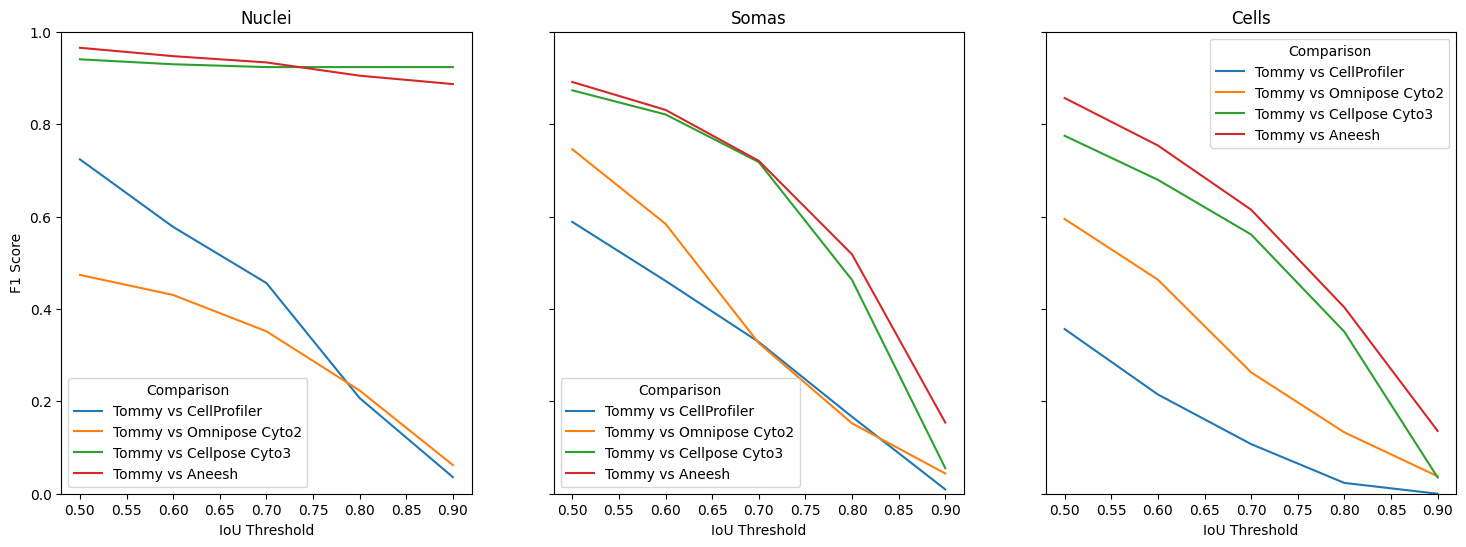

In [61]:
f, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for compartment, ax in zip(["Nuclei", "Somas", "Cells"], axs):
    sns.lineplot(data=df[df["Compartment"] == compartment], x="IoU Threshold", y="F1 Score", hue="Comparison", ax=ax)
    ax.set_title(compartment)

plt.ylim(0, 1.0)
#plt.suptitle("Cellpose Cyto3 Performance")
#plt.savefig("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/figures/performance.pdf")

# Analyze differences

In [175]:
df = pd.read_csv("/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/plate1/MyExpt_Image.csv")
cols_X = [c for c in df.columns if "Mean" in c or "Count" in c]
cols_Y = [c for c in df.columns if c == "Metadata_Field" or c == "Metadata_Plate"]

df = df[cols_X + cols_Y]
X = df[cols_X].values


In [176]:
field_1 = set(range(1,7)) | set(range(91,97)) | set(range(127,133))
field_2 = set(range(7,13)) | set(range(76,82)) | set(range(169,175))
field_3 = set(range(55,61)) | set(range(82,88)) | set(range(133,136)) | set(range(166,169))
field_4 = set(range(49,55)) | set(range(97,103)) | set(range(121,127))
field_5 = set(range(13,16)) | set(range(46,49)) | set(range(88,91)) | set(range(103,106)) | set(range(175,181))

perturbations = {x : 1 for x in field_1} | {x : 2 for x in field_2} | {x : 3 for x in field_3} | {x : 4 for x in field_4} | {x : 5 for x in field_5}
perturbations = {k: str(v) for k, v in perturbations.items()}

field_ae8 = set(range(1,16)) | set(range(46,61))
field_xh7 = set(range(76,106))
field_zkz = set(range(121,136)) | set(range(166,181))
lines = {f : "AE8iCTA" for f in field_ae8} | {f : "XH7iCTR" for f in field_xh7} | {f : "ZKZiCTR" for f in field_zkz}

df["Perturbation"] = df["Metadata_Field"].map(perturbations)
df["Cell Line"] = df["Metadata_Field"].map(lines)


In [178]:
reducer = umap.UMAP()
X_scaled = StandardScaler().fit_transform(X)
embedding = reducer.fit_transform(X_scaled)

df["UMAP1"] = embedding[:, 0]
df["UMAP2"] = embedding[:, 1]

In [182]:
df["Cell Line"].unique()

array(['AE8iCTA', 'XH7iCTR', 'ZKZiCTR'], dtype=object)

(90, 50)
Accuracy is 27.77777777777778
Confusion Matrix
[[4 0 0 0 0]
 [1 0 1 2 0]
 [2 0 1 0 0]
 [0 0 1 0 2]
 [0 1 2 1 0]]


/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


p-value: 0.4629


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

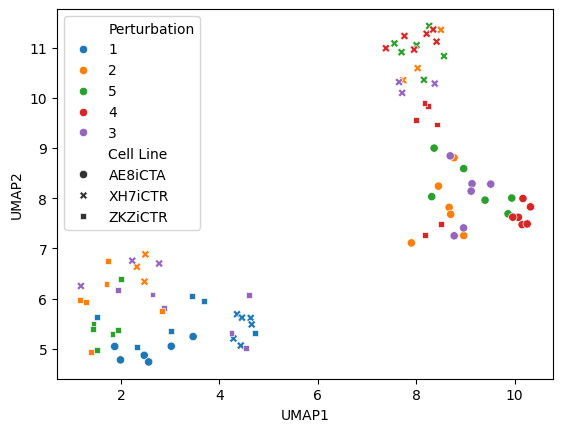

In [185]:
X = df[cols_X].values

line_to_num = {u : i for i, u in enumerate(df["Cell Line"].unique())}
x_line = np.array([line_to_num[line] for line in df["Cell Line"]])

X = np.concatenate((X, x_line[:, None]), axis=1)
y = df["Perturbation"].values

print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15, stratify=y)
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)*100

confusion_mat = confusion_matrix(y_test,y_pred)

print("Accuracy is",accuracy)
print("Confusion Matrix")
print(confusion_mat)

accs = []
for iter in range(10000):
    rand1 = np.random.choice(a=[0,1,2,3], size=1)
    row1 = np.zeros((1,4))
    for rand in rand1:
        row1[0,rand] += 1

    rand2 = np.random.choice(a=[0,1,2,3], size=4)
    row2 = np.zeros((1,4))
    for rand in rand2:
        row2[0,rand2] += 1

    rand3 = np.random.choice(a=[0,1,2,3], size=4)
    row3 = np.zeros((1,4))
    for rand in rand3:
        row3[0,rand] += 1

    rand4 = np.random.choice(a=[0,1,2,3], size=3)
    row4 = np.zeros((1,4))
    for rand in rand4:
        row4[0,rand] += 1

    rand_mat = np.concatenate((row1,row2,row3,row4), axis=0)
    acc = np.sum(rand_mat.diagonal())/np.sum(rand_mat)
    accs.append(acc)

accs = np.array(accs)

print(f"p-value: {np.sum(accs >= accuracy/100)/len(accs)}")
sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Perturbation", style="Cell Line")


/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy is 77.77777777777779
Confusion Matrix
[[5 0 1]
 [0 5 1]
 [0 2 4]]
p-value: 0.0032


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

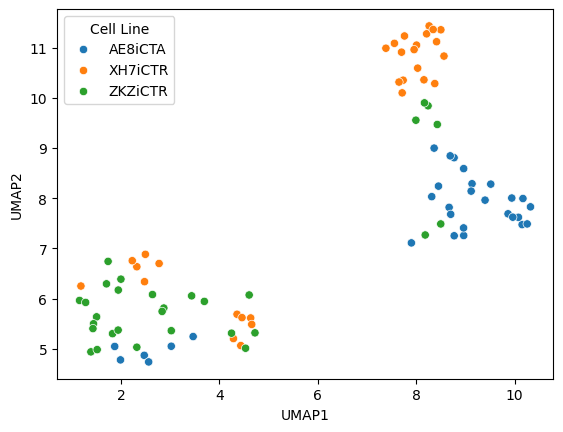

In [180]:
X = df[cols_X].values
y = df["Cell Line"].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15, stratify=y)
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test,y_pred)*100

confusion_mat = confusion_matrix(y_test,y_pred)

print("Accuracy is",accuracy)
print("Confusion Matrix")
print(confusion_mat)

accs = []
for iter in range(10000):
    rand1 = np.random.choice(a=[0,1], size=5)
    row1 = np.zeros((1,2))
    for rand in rand1:
        row1[0,rand] += 1

    rand2 = np.random.choice(a=[0,1], size=7)
    row2 = np.zeros((1,2))
    for rand in rand2:
        row2[0,rand2] += 1

    rand_mat = np.concatenate((row1,row2), axis=0)
    acc = np.sum(rand_mat.diagonal())/np.sum(rand_mat)
    accs.append(acc)

accs = np.array(accs)

print(f"p-value: {np.sum(accs >= accuracy/100)/len(accs)}")
sns.scatterplot(df, x="UMAP1", y="UMAP2", hue="Cell Line")